<a href="https://colab.research.google.com/github/maufonseca18/Challenge_TelecomX_alura_part_II/blob/main/Challenge_TelecomX_alura_parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import de los datos y de las librerías

In [11]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
#Import del data raw de la parte 1
url = "https://raw.githubusercontent.com/maufonseca18/Challenge_TelecomX_alura/refs/heads/main/datos_tratados.csv"
df = pd.read_csv(url)
df.head()

,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total,daily_expenses
0,0002-Orfbo,0,Female,0,1,1,9,1,0,Dsl,...,0,1,1,0,One Year,1,Mailed Check,65.6,593.30,2.186667
1,0003-Mknfe,0,Male,0,0,0,9,1,1,Dsl,...,0,0,0,1,Month-To-Month,0,Mailed Check,59.9,542.40,1.996667
2,0004-Tlhlj,1,Male,0,0,0,4,1,0,Fiber Optic,...,1,0,0,0,Month-To-Month,1,Electronic Check,73.9,280.85,2.463333
3,0011-Igkff,1,Male,1,1,0,13,1,0,Fiber Optic,...,1,0,1,1,Month-To-Month,1,Electronic Check,98.0,1237.85,3.266667
4,0013-Exchz,1,Female,1,1,0,3,1,0,Fiber Optic,...,0,1,1,0,Month-To-Month,1,Mailed Check,83.9,267.40,2.796667


In [13]:
#Sklear y imblearn
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from imblearn.over_sampling import SMOTENC
#Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
#Serialización
import pickle

RANDOM_STATE = 42
print("sklearn version:", sklearn.__version__)

sklearn version: 1.6.1


#Preparaciones iniciales (detección target, drop ids)

In [14]:
#detectar target
target_candidates = [c for c in df.columns if "churn" in c.lower() or "cancel" in c.lower()]
if not target_candidates:
    raise ValueError("No se encontró columna target 'Churn' o similar.")
target_col = target_candidates[0]
print("Target detected:", target_col)

#eliminar id-like
cols_to_drop = [c for c in df.columns if ('id' in c.lower() and c.lower() != target_col.lower())]
print("Columns to drop (id-like):", cols_to_drop)
df = df.drop(columns=cols_to_drop, errors='ignore')

#normalizar target si es texto
if df[target_col].dtype == object:
    df[target_col] = df[target_col].str.strip().str.lower().map({
        'yes':1,'y':1,'si':1,'sí':1,'true':1,'1':1,'no':0,'n':0,'false':0,'0':0
    })
    if df[target_col].isnull().any():
        df[target_col] = pd.factorize(df[target_col])[0]

print("Target value counts:")
display(df[target_col].value_counts())

Target detected: Churn
Columns to drop (id-like): ['customerID']
Target value counts:


,count
Churn,
0,5398
1,1869


#Código: EDA (info, describe, plots)

Info del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Churn                      7267 non-null   int64  
 1   customer_gender            7267 non-null   object 
 2   customer_SeniorCitizen     7267 non-null   int64  
 3   customer_Partner           7267 non-null   int64  
 4   customer_Dependents        7267 non-null   int64  
 5   customer_tenure            7267 non-null   int64  
 6   phone_PhoneService         7267 non-null   int64  
 7   phone_MultipleLines        7267 non-null   int64  
 8   internet_InternetService   7267 non-null   object 
 9   internet_OnlineSecurity    7267 non-null   int64  
 10  internet_OnlineBackup      7267 non-null   int64  
 11  internet_DeviceProtection  7267 non-null   int64  
 12  internet_TechSupport       7267 non-null   int64  
 13  internet_StreamingTV       726

None


Resumen numérico:


,count,mean,std,min,25%,50%,75%,max
Churn,7267.0,0.257190,0.437115,0.000000,0.000000,0.000000,1.000000,1.000000
customer_SeniorCitizen,7267.0,0.162653,0.369074,0.000000,0.000000,0.000000,0.000000,1.000000
customer_Partner,7267.0,0.484106,0.499782,0.000000,0.000000,0.000000,1.000000,1.000000
customer_Dependents,7267.0,0.300124,0.458343,0.000000,0.000000,0.000000,1.000000,1.000000
customer_tenure,7267.0,32.346498,24.571773,0.000000,9.000000,29.000000,55.000000,72.000000
phone_PhoneService,7267.0,0.902711,0.296371,0.000000,1.000000,1.000000,1.000000,1.000000
phone_MultipleLines,7267.0,0.421770,0.493876,0.000000,0.000000,0.000000,1.000000,1.000000
internet_OnlineSecurity,7267.0,0.285950,0.451897,0.000000,0.000000,0.000000,1.000000,1.000000
internet_OnlineBackup,7267.0,0.344571,0.475261,0.000000,0.000000,0.000000,1.000000,1.000000
internet_DeviceProtection,7267.0,0.342782,0.474672,0.000000,0.000000,0.000000,1.000000,1.000000


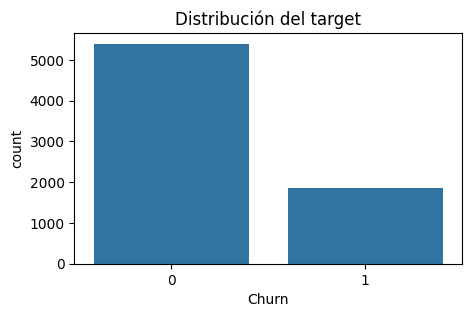

Categorical cols: ['customer_gender', 'internet_InternetService', 'account_Contract', 'account_PaymentMethod']
Numeric cols: ['customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure', 'phone_PhoneService', 'phone_MultipleLines', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_PaperlessBilling', 'account_Charges_Monthly', 'account_Charges_Total', 'daily_expenses']


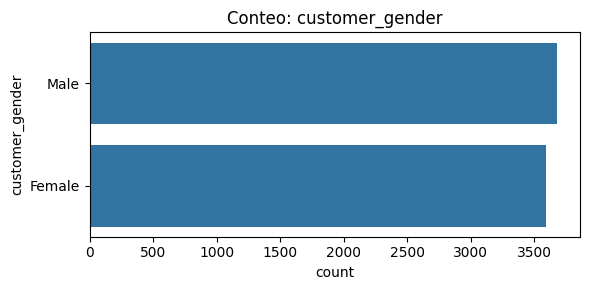

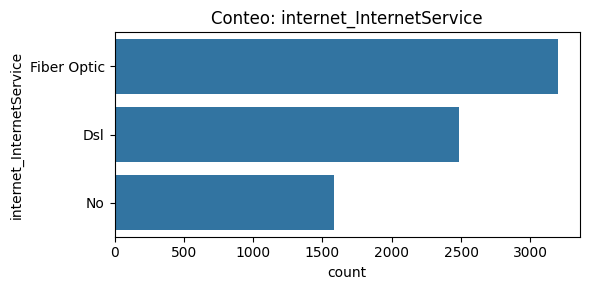

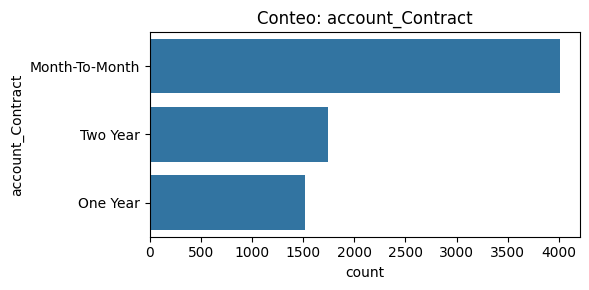

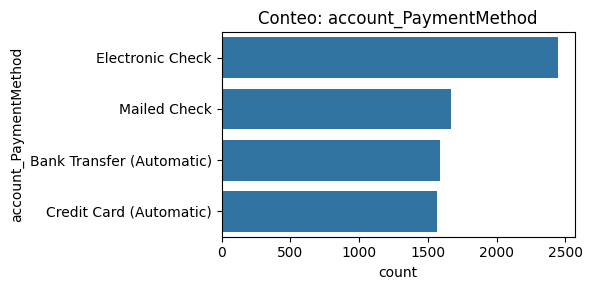

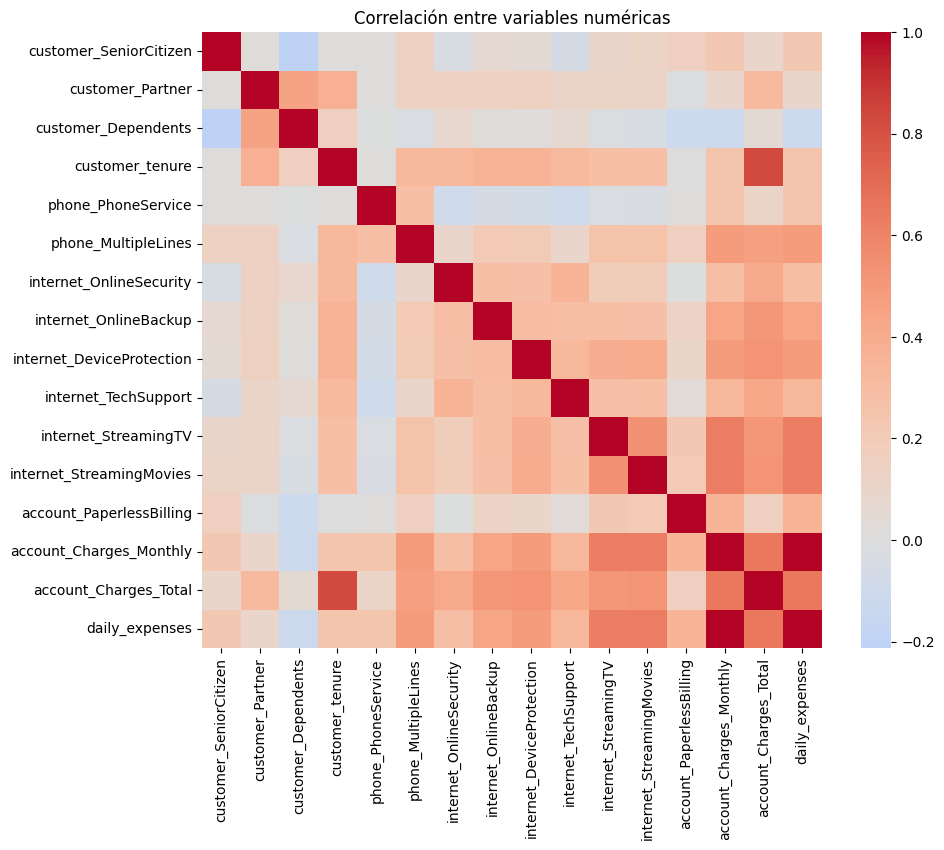

In [15]:
#EDA
print("Info del dataset:")
display(df.info())

print("\nResumen numérico:")
display(df.describe().T)

#Distribución target
plt.figure(figsize=(5,3))
sns.countplot(x=target_col, data=df)
plt.title("Distribución del target")
plt.show()

#Detectar columnas categóricas y numéricas
X_all = df.drop(columns=[target_col])
cat_cols = X_all.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X_all.select_dtypes(include=[np.number]).columns.tolist()
print("Categorical cols:", cat_cols)
print("Numeric cols:", num_cols)

#Conteo por categoría (ejemplo top 4 categóricas)
for c in cat_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(y=c, data=df, order=df[c].value_counts().index)
    plt.title(f"Conteo: {c}")
    plt.tight_layout()
    plt.show()

#Correlación numérica (heatmap)
if len(num_cols) > 1:
    plt.figure(figsize=(10,8))
    sns.heatmap(df[num_cols].corr(), cmap='coolwarm', center=0)
    plt.title("Correlación entre variables numéricas")
    plt.show()

#Split train/test estratificado

In [16]:
X = X_all.copy()
y = df[target_col].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Proporción target train:", y_train.mean(), " test:", y_test.mean())

Train shape: (5086, 20) Test shape: (2181, 20)
Proporción target train: 0.25717656311443177  test: 0.25722145804676755


#Balanceo con SMOTENC (robusto)

In [17]:
minority_prop = y_train.value_counts(normalize=True).min()
print("Minority proportion (train):", minority_prop)

for c in cat_cols:
    if c in X_train.columns:
        X_train[c] = X_train[c].astype(str)
        X_test[c]  = X_test[c].astype(str)

use_smote = (len(cat_cols) > 0) and (minority_prop < 0.35)
if use_smote:
   #SMOTENC espera enteros para categorías
    ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train_ord = X_train.copy()
    X_train_ord[cat_cols] = ord_enc.fit_transform(X_train[cat_cols])
    #matriz orden num_cols + cat_cols
    cols_order = [c for c in (num_cols + cat_cols) if c in X_train_ord.columns]
    X_train_matrix = X_train_ord[cols_order].to_numpy()

#índices categóricos en la matriz: después de las numéricas
    n_num = len([c for c in num_cols if c in cols_order])
    n_cat = len([c for c in cat_cols if c in cols_order])
    cat_feature_indices = list(range(n_num, n_num + n_cat))
    cat_feature_indices = [i for i in cat_feature_indices if i < X_train_matrix.shape[1]]

    smote = SMOTENC(categorical_features=cat_feature_indices, random_state=RANDOM_STATE)
    X_res_np, y_res = smote.fit_resample(X_train_matrix, y_train.to_numpy())
    print("After SMOTENC, shapes:", X_res_np.shape, y_res.shape)

 #Reconstruir DataFrame
    X_res = pd.DataFrame(X_res_np, columns=cols_order)
    #Transformar cat cols: round -> int -> str (para OHE estable)
    for c in cat_cols:
        if c in X_res.columns:
            X_res[c] = X_res[c].round().astype(int).astype(str)
    #Asegurar numeric types
    for n in num_cols:
        if n in X_res.columns:
            X_res[n] = pd.to_numeric(X_res[n], errors='coerce')

        X_train_bal = X_res.reset_index(drop=True)
        y_train_bal = pd.Series(y_res).reset_index(drop=True)
    else:
        print("SMOTENC no aplicado; se usa X_train original")
        X_train_bal = X_train.copy()
        y_train_bal = y_train.copy()



Minority proportion (train): 0.25717656311443177
After SMOTENC, shapes: (7556, 20) (7556,)
SMOTENC no aplicado; se usa X_train original


#Crear preprocessors y pipelines

In [18]:
#OneHotEncoder compatibilidad
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

#Filtrar columnas efectivas (si SMOTE removió alguna)
cat_cols_used = [c for c in cat_cols if c in X_train_bal.columns and c in X_test.columns]
num_cols_used = [c for c in num_cols if c in X_train_bal.columns and c in X_test.columns]

print("Final categorical cols used:", cat_cols_used)
print("Final numeric cols used:", num_cols_used)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', ohe, cat_cols_used),
        ('num', StandardScaler(), num_cols_used)
    ]
)

#Pipelines modelos base
pipe_lr = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])
pipe_rf = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE))])
pipe_svc = Pipeline([('pre', preprocessor), ('clf', SVC(probability=True, random_state=RANDOM_STATE))])
pipe_xgb = Pipeline([('pre', preprocessor), ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE))])

Final categorical cols used: ['customer_gender', 'internet_InternetService', 'account_Contract', 'account_PaymentMethod']
Final numeric cols used: ['customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure', 'phone_PhoneService', 'phone_MultipleLines', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_PaperlessBilling', 'account_Charges_Monthly', 'account_Charges_Total', 'daily_expenses']


#Entrenamiento y evaluación (función de evaluación)

In [19]:
#Función de evaluación
def evaluar(pipe, X_test_local, y_test_local, nombre="Modelo"):
    y_hat = pipe.predict(X_test_local)
    y_proba = None
    try:
        y_proba = pipe.predict_proba(X_test_local)[:,1]
    except:
        try:
            y_proba = pipe.decision_function(X_test_local)
        except:
            y_proba = None

    acc = accuracy_score(y_test_local, y_hat)
    prec = precision_score(y_test_local, y_hat, zero_division=0)
    rec = recall_score(y_test_local, y_hat, zero_division=0)
    f1 = f1_score(y_test_local, y_hat, zero_division=0)
    auc = roc_auc_score(y_test_local, y_proba) if y_proba is not None else None

    print(f"\n>>> {nombre} <<<")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {auc}")
    print(classification_report(y_test_local, y_hat, zero_division=0))
    print("Confusion matrix:\n", confusion_matrix(y_test_local, y_hat))

    return {"Modelo": nombre, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc}, y_proba

#Entrenar y evaluar cada pipeline
models = {
    "LogisticRegression": pipe_lr,
    "RandomForest": pipe_rf,
    "SVC": pipe_svc,
    "XGBoost": pipe_xgb
}

results = []
probas = {}
for name, pipe in models.items():
    print(f"\nTraining {name} ...")
    pipe.fit(X_train_bal, y_train_bal)
    res, yp = evaluar(pipe, X_test, y_test, name)
    results.append(res)
    probas[name] = yp



Training LogisticRegression ...

>>> LogisticRegression <<<
Accuracy: 0.8010 | Precision: 0.6342 | Recall: 0.5348 | F1: 0.5803 | AUC: 0.8431625624436083
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1620
           1       0.63      0.53      0.58       561

    accuracy                           0.80      2181
   macro avg       0.74      0.71      0.72      2181
weighted avg       0.79      0.80      0.80      2181

Confusion matrix:
 [[1447  173]
 [ 261  300]]

Training RandomForest ...

>>> RandomForest <<<
Accuracy: 0.7831 | Precision: 0.5991 | Recall: 0.4742 | F1: 0.5294 | AUC: 0.8144913184128871
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1620
           1       0.60      0.47      0.53       561

    accuracy                           0.78      2181
   macro avg       0.71      0.68      0.69      2181
weighted avg       0.77      0.78      0.77      2181

Conf

#Curvas ROC y Precision-Recall

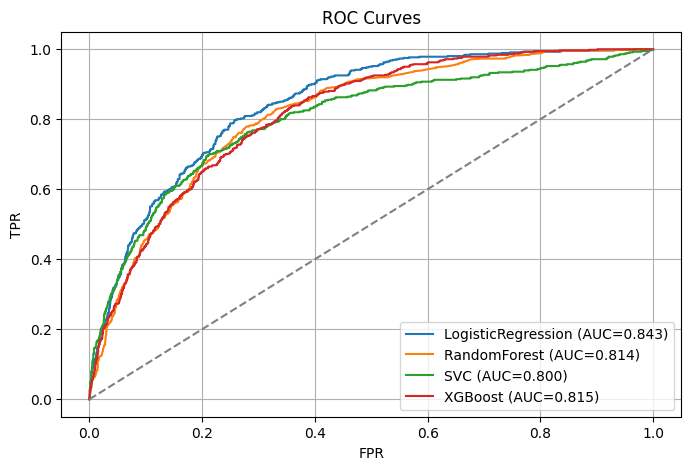

<Figure size 800x500 with 0 Axes>

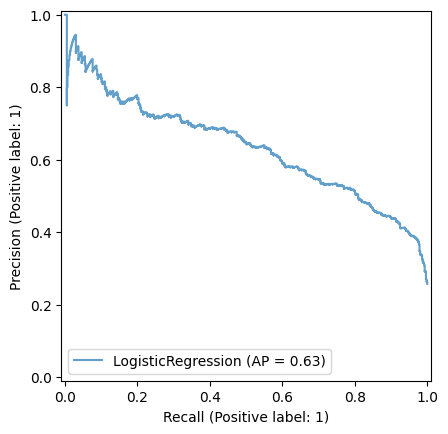

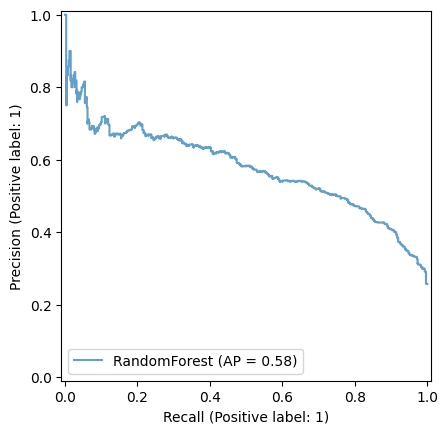

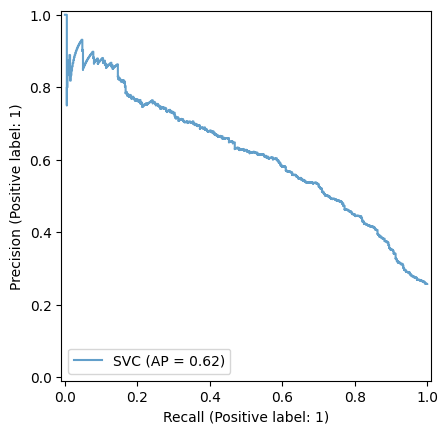

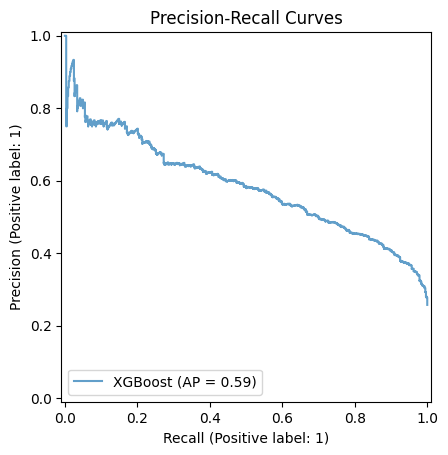

In [20]:
#ROC Curves
plt.figure(figsize=(8,5))
for name, yp in probas.items():
    if yp is not None:
        fpr, tpr, _ = roc_curve(y_test, yp)
        auc_v = roc_auc_score(y_test, yp)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_v:.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curves"); plt.legend(); plt.grid(True)
plt.show()

#Precision-Recall
plt.figure(figsize=(8,5))
from sklearn.metrics import PrecisionRecallDisplay
for name, yp in probas.items():
    if yp is not None:
        PrecisionRecallDisplay.from_predictions(y_test, yp, name=name, alpha=0.7)
plt.title("Precision-Recall Curves")
plt.show()


#Importancia de features (RF + OHE)

,0
account_Charges_Total,0.162264
account_Charges_Monthly,0.135779
customer_tenure,0.134350
daily_expenses,0.132106
account_Contract_Month-To-Month,0.054885
internet_InternetService_Fiber Optic,0.031221
account_PaymentMethod_Electronic Check,0.030870
account_PaperlessBilling,0.023722
customer_Partner,0.020817
account_Contract_Two Year,0.020304


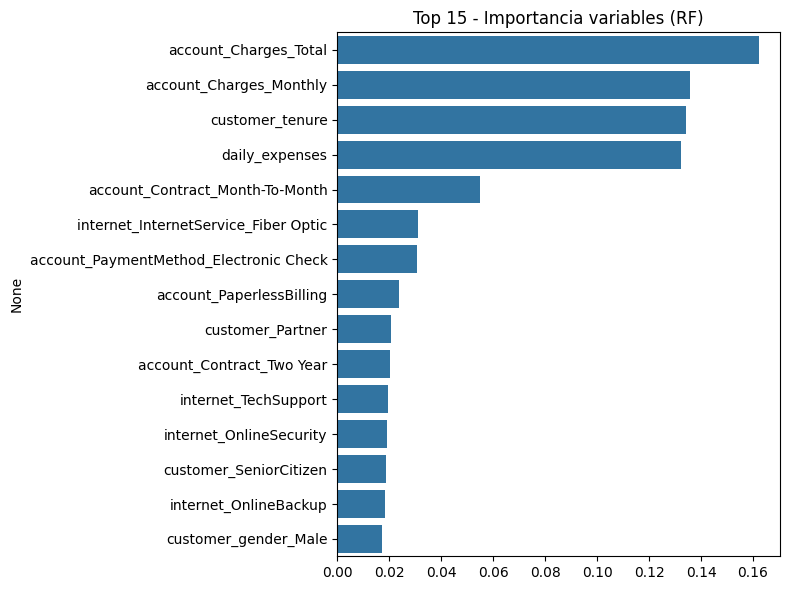

In [21]:
#Expandir training balanceado con get_dummies para ver nombres reales tras OHE
X_train_ohe = pd.get_dummies(X_train_bal, columns=cat_cols_used)
rf_raw = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
rf_raw.fit(X_train_ohe, y_train_bal)

feat_imp = pd.Series(rf_raw.feature_importances_, index=X_train_ohe.columns).sort_values(ascending=False)
display(feat_imp.head(20))

plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.head(15).values, y=feat_imp.head(15).index)
plt.title("Top 15 - Importancia variables (RF)")
plt.tight_layout()
plt.show()


In [22]:
#Conclusión

In [36]:
#Conclusión preliminar automática (editable)

df_results = pd.DataFrame(results).sort_values(by='F1', ascending=False).reset_index(drop=True)

print("Dataset:", df.shape)
print("Target:", target_col, "proporción global:", y.mean())

print("\nMejores modelos ordenados por F1:")
display(df_results)

top_model_name = df_results.loc[0, "Modelo"]
print(f"\nModelo con mejor F1: {top_model_name}")

print("\nRecomendaciones:")
print("- Focalizar retención en segmentos definidos por las variables más importantes (ver top features).")
print("- Revisar planes 'account_Contract' y método de pago 'account_PaymentMethod' si aparecen entre los top features.")
print("- Implementar campañas de retención para clientes con tenure bajo y charges altos.")

Dataset: (7267, 21)
Target: Churn proporción global: 0.257190037154259

Mejores modelos ordenados por F1:


,Modelo,Accuracy,Precision,Recall,F1,AUC
0,LogisticRegression,0.801009,0.634249,0.534759,0.580271,0.843163
1,SVC,0.795048,0.638350,0.468806,0.540596,0.800086
2,XGBoost,0.781751,0.591006,0.491979,0.536965,0.814667
3,RandomForest,0.783127,0.599099,0.474153,0.529353,0.814491



Modelo con mejor F1: LogisticRegression

Recomendaciones:
- Focalizar retención en segmentos definidos por las variables más importantes (ver top features).
- Revisar planes 'account_Contract' y método de pago 'account_PaymentMethod' si aparecen entre los top features.
- Implementar campañas de retención para clientes con tenure bajo y charges altos.
